In [1]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import math
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [2]:
path = 'E:/Koulu/data/muu/Alberding_Pasila/pasivrs01-2122-2-checkInit'
# path = 'E:/Koulu/data/muu/Alberding_joensuu/MJOE-vrs-2275-5-checkInit'
pasdir = 'E:/Koulu/data/muu/Alberding_Pasila'
joedir = 'E:/Koulu/data/muu/Alberding_joensuu'

df = pd.read_csv(path, delimiter=';')
df['datetime'] = pd.to_datetime(df['Event Time [UTC]']).dt.round('5min')

# df = df.drop(columns=['startDelay', 'TTFA[s]', 'Sigma HDOP', 
#                         'Sigma H', 'Sigma NE', 'Epochs', 'Data-Age[s]', 'checkType',
#                       'Sigma Sat.', 'Sigma Data-Age', 'Sigma N', 'Sigma E', 
#                       '# of Sat.', 'initTyp', 'Solution', 'Event Time [UTC]'])

df = df[['datetime', 'dN[cm]', 'dE[cm]', 'dNE[cm]', 'HDOP']]

df = df.loc[(df['datetime'].dt.time >= dt.time(6)) & (df['datetime'].dt.time <= dt.time(16))]
df = df.groupby('datetime').mean().reset_index()
df

datetime      dN[cm]      dE[cm]      dNE[cm]      HDOP
0   2020-09-08 06:00:00  279.933333 -746.600000  1119.133333  0.633333
1   2020-09-08 06:05:00  603.866667 -376.966667   717.266667  0.666667
2   2020-09-08 06:10:00 -668.475000 -981.425000  1190.175000  0.525000
3   2020-09-08 06:15:00 -636.766667 -822.200000  1040.233333  0.500000
4   2020-09-08 06:20:00  210.833333 -731.600000   928.333333  0.533333
..                  ...         ...         ...          ...       ...
116 2020-09-08 15:40:00   -1.650000    1.025000     1.975000  0.500000
117 2020-09-08 15:45:00   -1.166667    0.600000     1.333333  0.500000
118 2020-09-08 15:50:00   -1.333333    0.300000     1.400000  0.500000
119 2020-09-08 15:55:00   -1.666667    0.466667     1.733333  0.500000
120 2020-09-08 16:00:00   -0.875000    0.950000     1.300000  0.500000

[121 rows x 5 columns]

In [3]:
ORGANIZE = False
pasila = []
pasiladates = []
joensuu = []
joensuudates = []
fails = []

dates = pd.read_csv('data/dates.csv')
dates = pd.to_datetime(dates['date']).dt.date.values

if ORGANIZE:    
    i = 1
    nfiles = len(os.listdir(pasdir))

    nlsdf = pd.DataFrame(columns=['datetime', 'dN[cm]', 'dE[cm]', 'dNE[cm]', 'HDOP', 'asema'])
    
    print('Processing Pasila files...')
    for file in os.listdir(pasdir):
        print(f'Processing file {file}, {i}/{nfiles}, {100*(i/nfiles):.2f}%', end='\r')
        i += 1

        try:
            df = pd.read_csv(os.path.join(pasdir, file), delimiter=';')
            date = pd.to_datetime(df['Event Time [UTC]'][0]).date()
            if date in dates:
                pasila.append(str(file))
                pasiladates.append(date)

                df['datetime'] = pd.to_datetime(df['Event Time [UTC]']).dt.round('5min')
                df = df[['datetime', 'dN[cm]', 'dE[cm]', 'dNE[cm]', 'HDOP']]
                df = df.loc[(df['datetime'].dt.time >= dt.time(6)) & (df['datetime'].dt.time <= dt.time(16))]
                df = df.groupby('datetime').mean().reset_index()
                df['asema'] = 'pasila'

                nlsdf = pd.concat([nlsdf, df], ignore_index=True)
    
        except:
            fails.append(pasdir+'/'+str(file))
    
    i = 1
    nfiles = len(os.listdir(joedir))
    print('Processing Joensuu files...')
    for file in os.listdir(joedir):
        print(f'Processing file {file}, {i}/{nfiles}, {100*(i/nfiles):.2f}%', end='\r')
        i += 1

        try:
            df = pd.read_csv(os.path.join(joedir, file), delimiter=';')
            date = pd.to_datetime(df['Event Time [UTC]'][0]).date()
            if date in dates:
                joensuu.append(str(file))
                joensuudates.append(date)

                df['datetime'] = pd.to_datetime(df['Event Time [UTC]']).dt.round('5min')
                df = df[['datetime', 'dN[cm]', 'dE[cm]', 'dNE[cm]', 'HDOP']]
                df = df.loc[(df['datetime'].dt.time >= dt.time(6)) & (df['datetime'].dt.time <= dt.time(16))]
                df = df.groupby('datetime').mean().reset_index()
                df['asema'] = 'joensuu'

                nlsdf = pd.concat([nlsdf, df], ignore_index=True)
    
        except:
            fails.append(joedir+'/'+str(file))
    
    nlsdf = nlsdf.sort_values('datetime')
    nlsdf.to_csv('data/NLSdf.csv', index=False)

    dif1 = set(dates).difference(pasiladates)
    dif2 = set(dates).difference(joensuudates)

    print(sorted(list(dif1&dif2)))

else:
    nlsdf = pd.read_csv('data/NLSdf.csv')
    nlsdf['datetime'] = pd.to_datetime(nlsdf['datetime'])
    print(nlsdf.head(10))


             datetime     dN[cm]     dE[cm]    dNE[cm]  HDOP   asema
0 2019-01-16 06:10:00  21.500000  23.500000  31.800000   0.4  pasila
1 2019-01-16 06:30:00  12.000000  28.000000  30.500000   0.4  pasila
2 2019-01-16 06:45:00  33.200000  14.400000  36.200000   0.4  pasila
3 2019-01-16 06:50:00  37.700000   2.600000  37.800000   0.4  pasila
4 2019-01-16 06:55:00  35.000000  -1.225000  35.100000   0.4  pasila
5 2019-01-16 07:00:00  38.033333  -3.566667  38.200000   0.4  pasila
6 2019-01-16 07:05:00  47.566667 -10.400000  48.733333   0.4  pasila
7 2019-01-16 07:10:00  62.625000 -12.850000  63.975000   0.4  pasila
8 2019-01-16 07:15:00  64.533333 -17.066667  66.766667   0.4  pasila
9 2019-01-16 07:20:00  70.233333  -7.033333  70.633333   0.4  pasila


In [4]:
hairiopv = nlsdf.loc[(nlsdf['datetime'].dt.date == dt.date(2023,2,27))]
clusters = pd.read_csv('data/clusterdf.csv', sep=',')
clusters['dates'] = pd.to_datetime(clusters['dates'])

finaldf = pd.merge(nlsdf, clusters, how='left', left_on=nlsdf['datetime'].dt.date, right_on=clusters['dates'].dt.date)
finaldf = finaldf.drop(columns=['key_0', 'dates'])
finaldf[list(clusters.columns[1:])] = finaldf[list(clusters.columns[1:])].astype('category')
finaldf

datetime     dN[cm]     dE[cm]    dNE[cm]  HDOP    asema  \
0     2019-01-16 06:10:00  21.500000  23.500000  31.800000   0.4   pasila   
1     2019-01-16 06:30:00  12.000000  28.000000  30.500000   0.4   pasila   
2     2019-01-16 06:45:00  33.200000  14.400000  36.200000   0.4   pasila   
3     2019-01-16 06:50:00  37.700000   2.600000  37.800000   0.4   pasila   
4     2019-01-16 06:55:00  35.000000  -1.225000  35.100000   0.4   pasila   
...                   ...        ...        ...        ...   ...      ...   
28586 2023-05-07 15:50:00  -0.050000  -0.525000   0.550000   0.5  joensuu   
28587 2023-05-07 15:55:00   1.333333  -0.700000   1.466667   0.5   pasila   
28588 2023-05-07 15:55:00   0.100000  -0.433333   0.600000   0.5  joensuu   
28589 2023-05-07 16:00:00   1.475000  -0.450000   1.525000   0.5   pasila   
28590 2023-05-07 16:00:00   0.566667  -0.333333   0.666667   0.5  joensuu   

        k2   k3   k4   k5   k6   k7   k8   k9  k10   k15  k25   k30  
0      1.0  0.0  0.0  0.0  1.0  1.0  6.0  1.0  1.0   2.0  1.0  23.0  
1      1.0  0.0  0.0  0.0  1.0  1.0  6.0  1.0  1.0   2.0  1.0  23.0  
2      1.0  0.0  0.0  0.0  1.0  1.0  6.0  1.0  1.0   2.0  1.0  23.0  
3      1.0  0.0  0.0  0.0  1.0  1.0  6.0  1.0  1.0   2.0  1.0  23.0  
4      1.0  0.0  0.0  0.0  1.0  1.0  6.0  1.0  1.0   2.0  1.0  23.0  
...    ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   ...  
28586  0.0  0.0  3.0  0.0  3.0  0.0  1.0  8.0  3.0  11.0  8.0  29.0  
28587  0.0  0.0  3.0  0.0  3.0  0.0  1.0  8.0  3.0  11.0  8.0  29.0  
28588  0.0  0.0  3.0  0.0  3.0  0.0  1.0  8.0  3.0  11.0  8.0  29.0  
28589  0.0  0.0  3.0  0.0  3.0  0.0  1.0  8.0  3.0  11.0  8.0  29.0  
28590  0.0  0.0  3.0  0.0  3.0  0.0  1.0  8.0  3.0  11.0  8.0  29.0  

[28591 rows x 18 columns]

In [5]:
nlsdf.corr(numeric_only=True)

dN[cm]    dE[cm]   dNE[cm]      HDOP
dN[cm]   1.000000  0.220673  0.859692 -0.056711
dE[cm]   0.220673  1.000000  0.184712 -0.045678
dNE[cm]  0.859692  0.184712  1.000000 -0.025928
HDOP    -0.056711 -0.045678 -0.025928  1.000000

In [6]:
from scipy.stats import f_oneway

for col in finaldf.columns:
    if col.startswith('k'):
        groups = [group['HDOP'].dropna().values for _, group in finaldf.groupby(col)]
        if len(groups) > 1:
            stat, p = f_oneway(*groups)
            print(f"{col}: F-statistic = {stat:.2f}, p-value = {p:.4e}")

k2: F-statistic = 346.67, p-value = 6.5462e-77
k3: F-statistic = 8.00, p-value = 3.3681e-04
k4: F-statistic = 96.72, p-value = 2.8145e-62
k5: F-statistic = 4.34, p-value = 1.6422e-03
k6: F-statistic = 70.98, p-value = 4.5455e-74
k7: F-statistic = 59.64, p-value = 9.7513e-74
k8: F-statistic = 66.24, p-value = 3.2365e-95
k9: F-statistic = 53.77, p-value = 3.2515e-87
k10: F-statistic = 45.71, p-value = 2.1184e-82
k15: F-statistic = 22.87, p-value = 1.6865e-59
k25: F-statistic = 41.70, p-value = 2.4537e-192
k30: F-statistic = 94.20, p-value = 0.0000e+00


C:\Users\Maria\AppData\Local\Temp\ipykernel_15008\2930637952.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['HDOP'].dropna().values for _, group in finaldf.groupby(col)]


In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=finaldf['HDOP'], groups=finaldf['k3'], alpha=0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0184 0.0933  -0.002  0.0387  False
   0.0    2.0   -0.026  0.006 -0.0465 -0.0056   True
   0.0    nan  -0.0131 0.0908 -0.0276  0.0013  False
   1.0    2.0  -0.0444 0.0004 -0.0731 -0.0157   True
   1.0    nan  -0.0315 0.0061 -0.0563 -0.0067   True
   2.0    nan   0.0129 0.5419  -0.012  0.0378  False
----------------------------------------------------


In [8]:
data_dir = "data/keog/"

os.environ['OMP_NUM_THREADS'] = '1'
dataframes = []
dates = []

for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_dir, file))
        dataframes.append(df)

heatmaps = []  
heatmaps_imputed = []  

imputer = SimpleImputer(strategy='mean')

for df in dataframes:
    XX, YY = np.meshgrid(df['time_seconds'].unique(), df['gdlat'].unique())
    ZZ = df['blrmvd'].values
    ZZ = np.reshape(ZZ, XX.T.shape).T

    heatmaps.append(ZZ)

    hmi = imputer.fit_transform(ZZ).flatten()
    if hmi.size == 1125:
        heatmaps_imputed.append(hmi)
        first_date = df['datetime'].iloc[0][:10]
        dates.append(first_date)
    else:
        continue

heatmaps_imputed = np.vstack(heatmaps_imputed)

c:\Users\Maria\anaconda3\envs\gradu\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [106]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\Maria\anaconda3\envs\gradu\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [59 60 61 62]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Cluster 0: 1 heatmaps


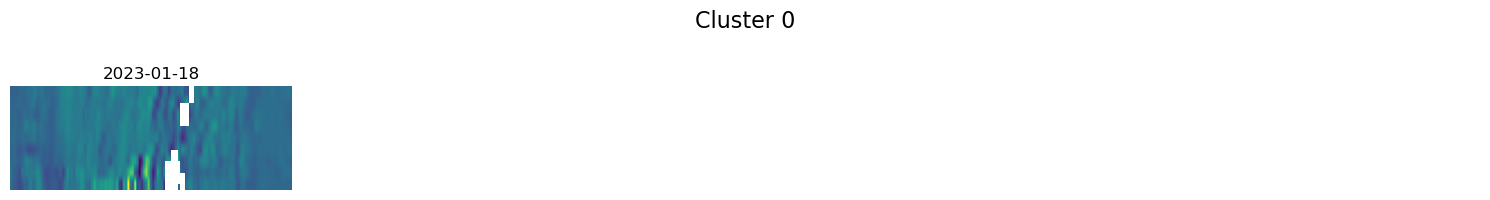

Cluster 1: 108 heatmaps


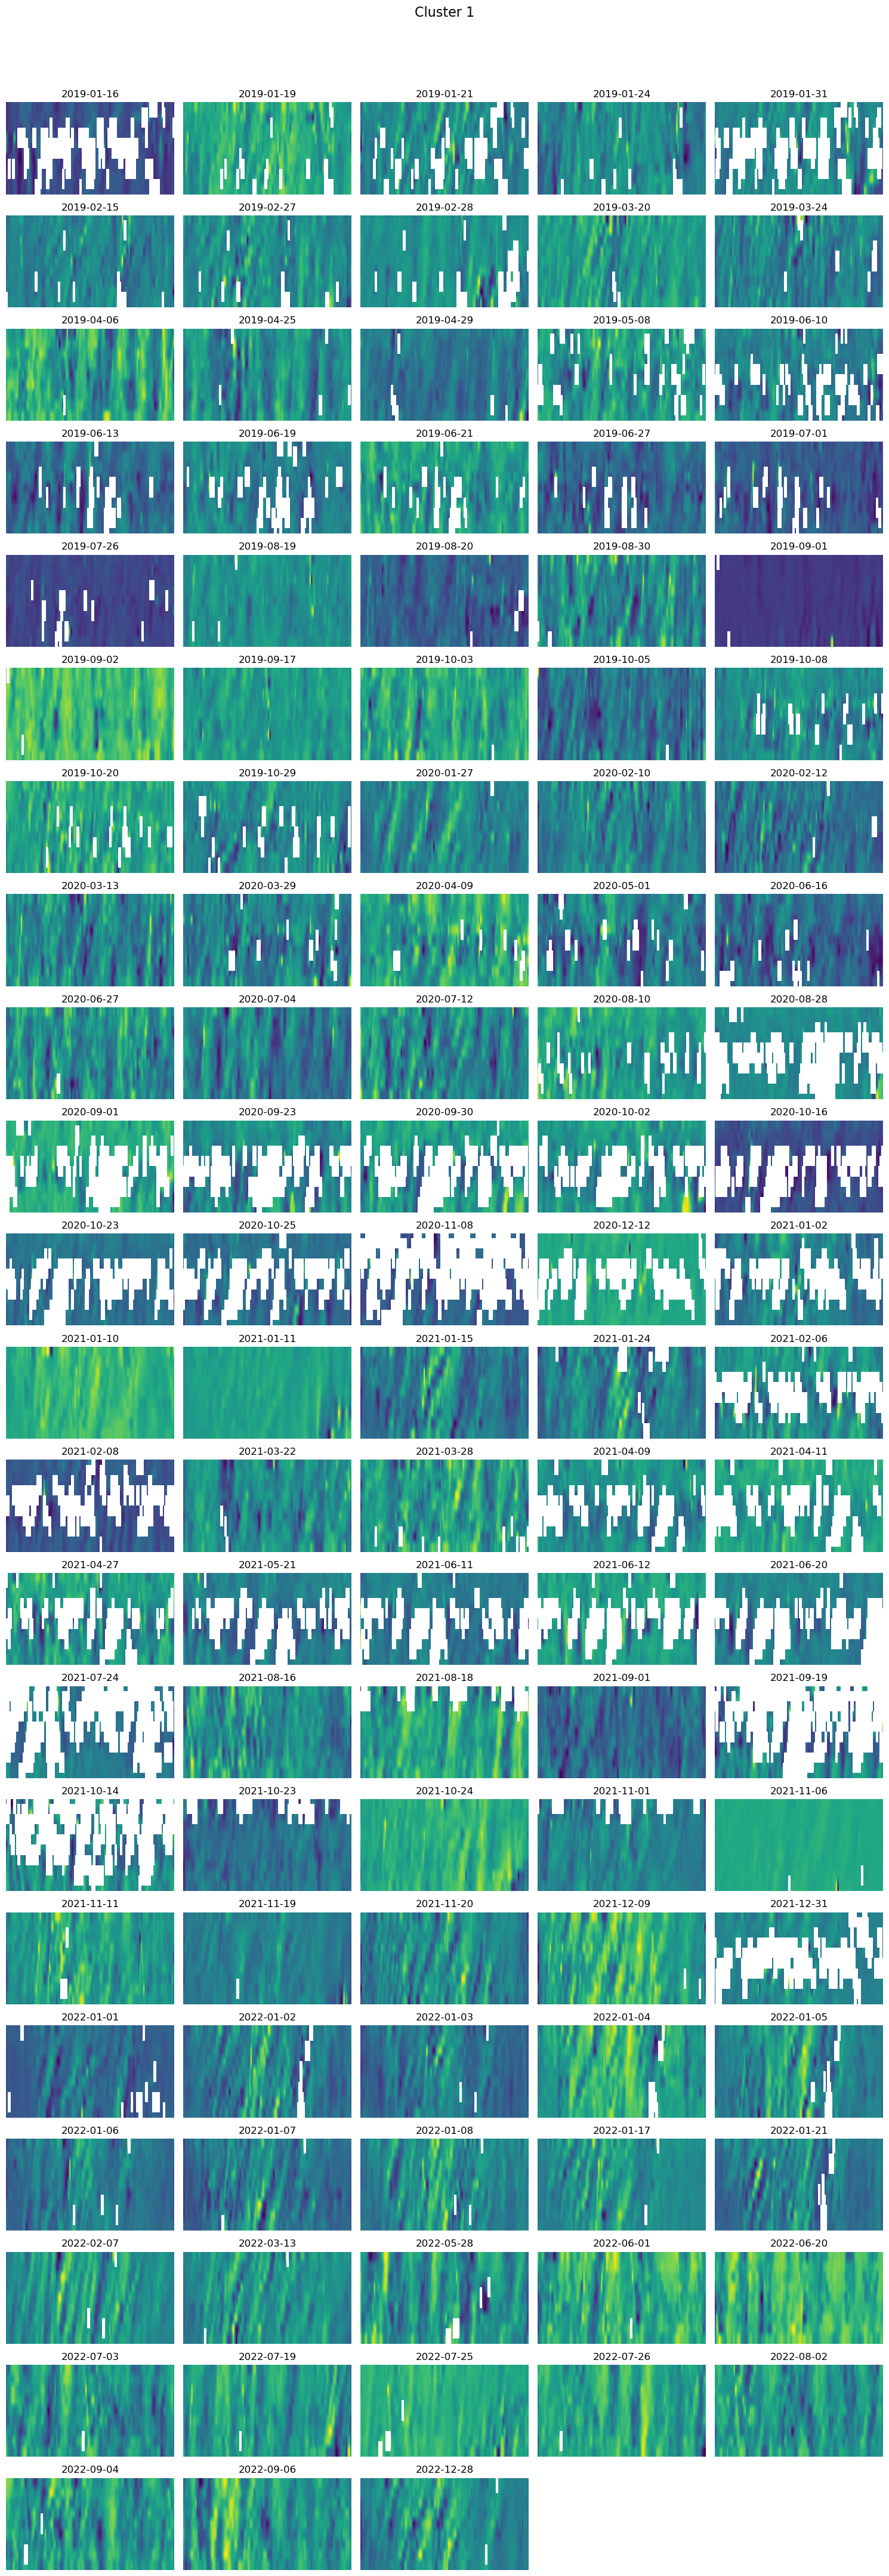

Cluster 2: 1 heatmaps


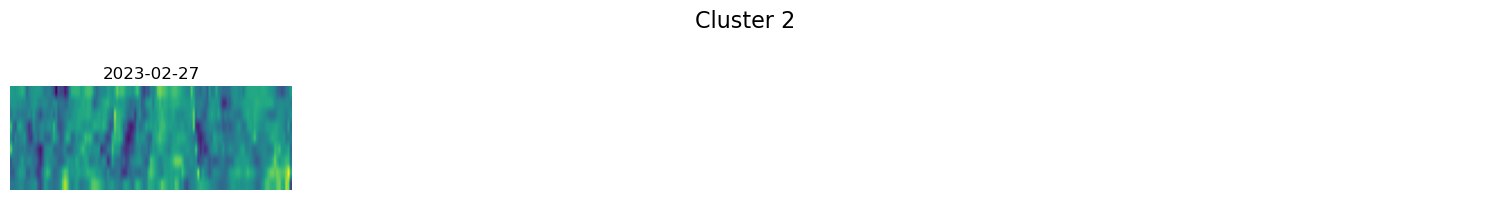

Cluster 3: 20 heatmaps


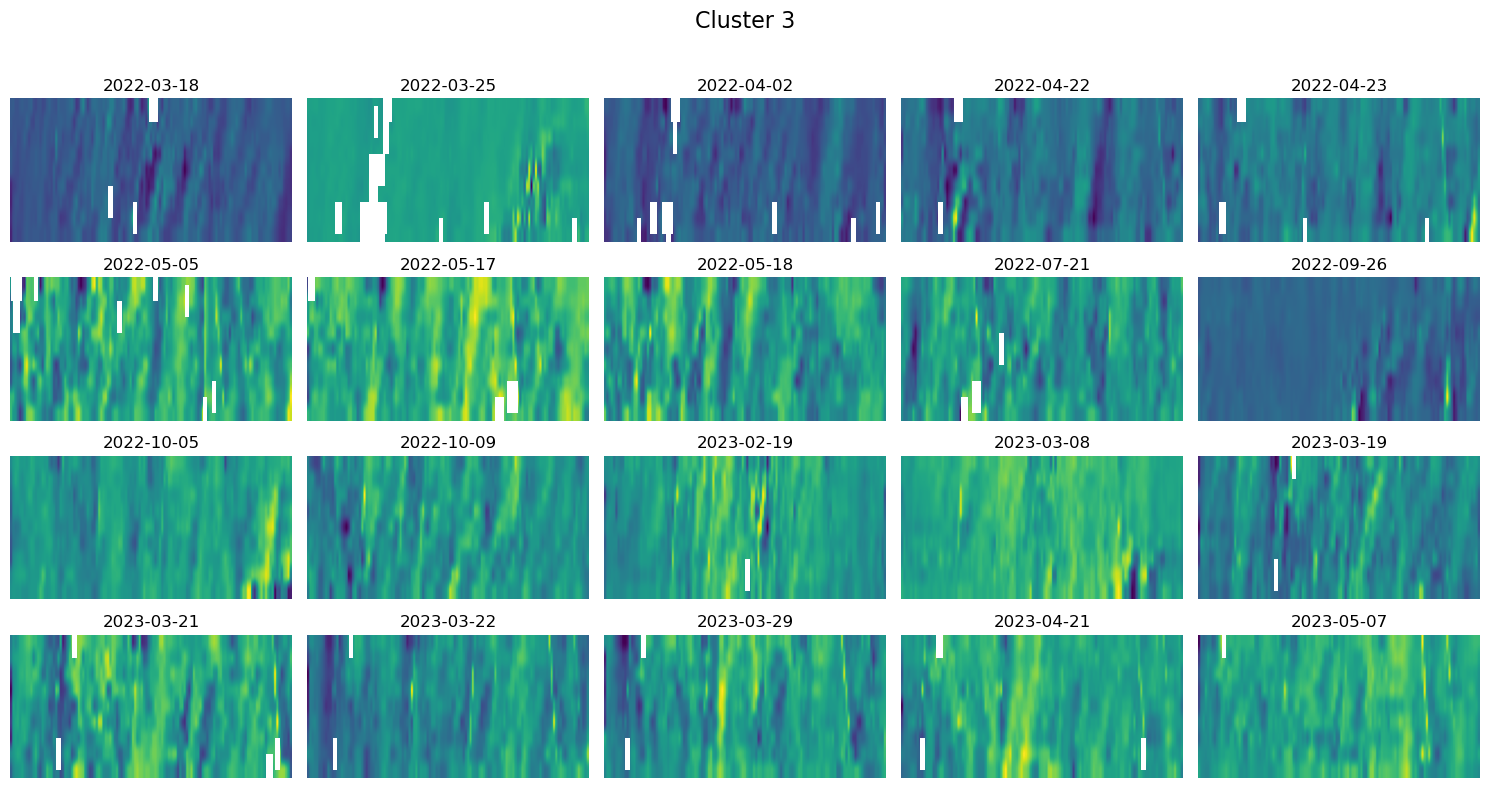

Cluster 4: 8 heatmaps


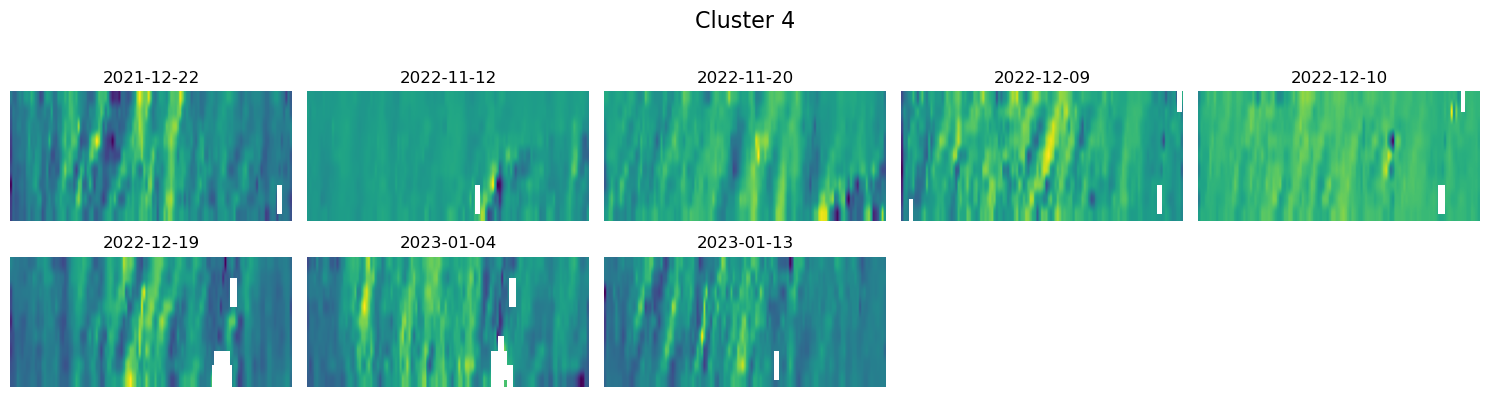

Cluster 5: 1 heatmaps


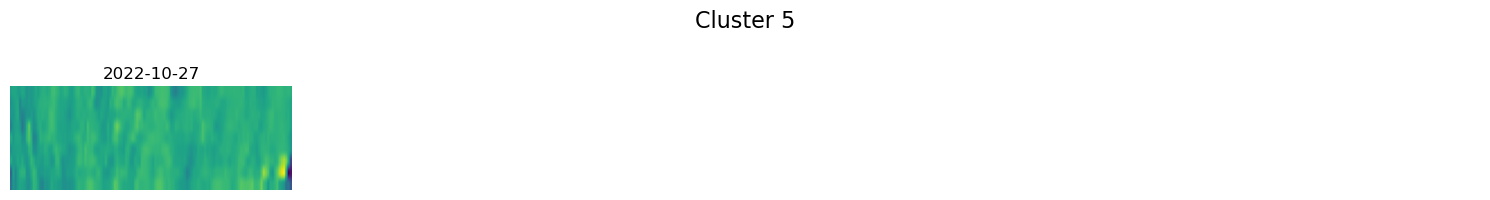

In [13]:
PRINT = True
k = 6


if PRINT:
    for i in range(k):
        labels = np.array(clusters[f'k{k}'])
        cluster_indices = np.where(labels == i)[0]
        n_images = len(cluster_indices)
        print(f"Cluster {i}: {n_images} heatmaps")

        # Setup subplot grid
        n_cols = 5
        n_rows = math.ceil(n_images / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
        axes = axes.flatten()  # Flatten for easy indexing

        for j, idx in enumerate(cluster_indices):
            ax = axes[j]
            ax.imshow(heatmaps[idx], aspect='auto', cmap='viridis')
            ax.set_title(f"{dates[idx]}")
            ax.axis('off')  # Hide axes for cleaner layout

        # Hide unused subplots
        for b in range(j+1, len(axes)):
            axes[b].axis('off')

        fig.suptitle(f'Cluster {i}', fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for title
        plt.show()